In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
df = pd.read_csv('rare_species_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11983 entries, 0 to 11982
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rarespecies_id  11983 non-null  object
 1   eol_content_id  11983 non-null  int64 
 2   eol_page_id     11983 non-null  int64 
 3   kingdom         11983 non-null  object
 4   phylum          11983 non-null  object
 5   class           11983 non-null  object
 6   order           11983 non-null  object
 7   family          11983 non-null  object
 8   genus           11983 non-null  object
 9   species         11983 non-null  object
 10  sciName         11983 non-null  object
 11  common          11983 non-null  object
 12  file_name       11983 non-null  object
 13  is_endangered   11983 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


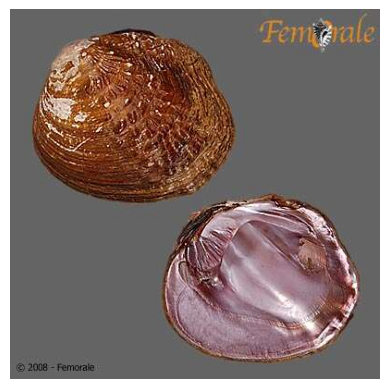

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
for i in df['file_name']:
    image = Image.open(i)
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()
    break

In [13]:
df['is_endangered'] = df['is_endangered'].astype(str)

✅ 2. Train/Validation/Test Split

Split the dataset based on the file_name and is_endangered columns:

In [14]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['is_endangered'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['is_endangered'], random_state=42)


✅ 3. Create Image Data Generators

Use ImageDataGenerator with flow from DataFrame:

In [ ]:


img_size = (224, 224)

train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, rotation_range=10)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='is_endangered',
    target_size=img_size,
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_data = val_test_gen.flow_from_dataframe(
    val_df,
    x_col='file_name',
    y_col='is_endangered',
    target_size=img_size,
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_data = val_test_gen.flow_from_dataframe(
    test_df,
    x_col='file_name',
    y_col='is_endangered',
    target_size=img_size,
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 8388 validated image filenames belonging to 2 classes.
Found 1797 validated image filenames belonging to 2 classes.
Found 1798 validated image filenames belonging to 2 classes.


In [17]:
# ✅ 4. Build the CNN Model (Transfer Learning: MobileNetV2)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# ✅ 5. Train the Model
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  6/263 ━━━━━━━━━━━━━━━━━━━━ 2:43 634ms/step - accuracy: 0.5460 - loss: 0.8186

/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 213s 804ms/step - accuracy: 0.5602 - loss: 0.7602 - val_accuracy: 0.6366 - val_loss: 0.6381
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 233s 887ms/step - accuracy: 0.6144 - loss: 0.6724 - val_accuracy: 0.6444 - val_loss: 0.6270
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.6382 - loss: 0.6513 - val_accuracy: 0.6489 - val_loss: 0.6220
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.6575 - loss: 0.6263 - val_accuracy: 0.6689 - val_loss: 0.6068
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.6573 - loss: 0.6261 - val_accuracy: 0.6667 - val_loss: 0.6083
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 248s 944ms/step - accuracy: 0.6695 - loss: 0.6175 - val_accuracy: 0.6733 - val_loss: 0.6117
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 211s 804ms/step - accuracy: 0.6712 - loss: 0.6159 - val_accuracy: 0.6717 - val_loss: 0.6094
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 213s 809ms/step - accuracy: 0.6705 - loss: 0.6110 - val_

In [19]:
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.2f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - accuracy: 0.6854 - loss: 0.5899
Test Accuracy: 0.68


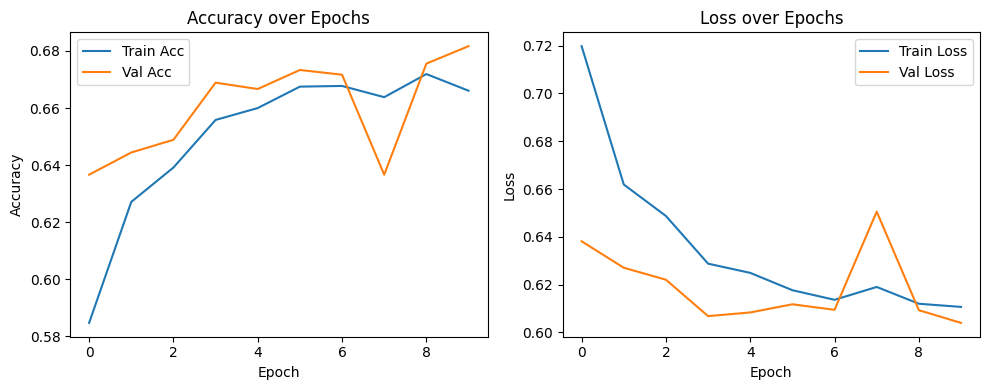

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your image
img_path = "/Users/muhammad/Desktop/rare-species/dataset/Animalia-Arthropoda-Arachnida-Araneae-Pisauridae-Dolomedes-plantarius/27912771_1198625_eol-full-size-copy.jpg"

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize (rescale)
img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, 224, 224, 3)


In [22]:
prediction = model.predict(img_array)

# Since you're doing binary classification with sigmoid:
if prediction[0][0] > 0.5:
    print("Predicted: Endangered (1)")
else:
    print("Predicted: Not Endangered (0)")

# Optional: print probability
print(f"Probability of being endangered: {prediction[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
Predicted: Endangered (1)
Probability of being endangered: 0.71


In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer and output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of the output neuron w.r.t. last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute guided mean
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [27]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 5.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array


In [30]:
img, img_array = preprocess_image(img_path)

# Name of your last convolutional layer (depends on the model you're using!)
last_conv_layer_name = "Conv_1"  # For MobileNetV2

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


/opt/homebrew/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


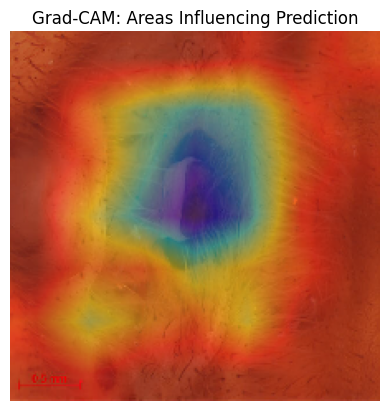

In [31]:
def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    
    img_np = np.array(img)
    superimposed_img = cv2.addWeighted(img_np, 1 - alpha, heatmap_colored, alpha, 0)
    return superimposed_img

# Show result
superimposed_img = overlay_heatmap(heatmap, img)
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("Grad-CAM: Areas Influencing Prediction")
plt.show()
